In [1]:
# Importing the libraries
import pandas as pd 
import numpy as numpy
import matplotlib.pyplot as plt 


# Loading the csv file
print('Loading the data...')
data = pd.read_csv('train.csv')


# Renaming the column
data = data.rename(columns={'electricity_consumption':'demand'})


# Dropping the ID Column
data.drop(['ID'], axis=1, inplace=True)


# Some attributes of data
n_examp, n_feat = data.shape


# Change the datetime column(a str) to datetime type
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')


# Get the range of time
min_time = min(data['datetime'])
max_time = max(data['datetime'])


# Make new columns of day, month, year, hour
data['year'] = data.datetime.dt.year
data['month'] = data.datetime.dt.month
data['day'] = data.datetime.dt.day
data['hour'] =  data.datetime.dt.hour


# Rearranging the columns
data = data[['datetime','year', 'month', 'day', 'hour',
			'temperature', 'var1', 'pressure', 'windspeed', 'var2','demand']]

# Dropping the datetime column since its redundant
data.drop(['datetime'], axis=1, inplace=True)



# Encoding var2 column with A:1 and B/C:0
data.var2.replace({'A':1, 'B': 0, 'C': 0}, inplace=True)


#Normalizing the columns
max_dem = max(data['demand'])
min_dem = min(data['demand'])
for col in data.columns:
    data[col] = (data[col] - min(data[col]))/(max(data[col]) - min(data[col]))

print(max_dem, min_dem)


Loading the data...
1386.0 174.0


In [2]:
# data.to_csv('data.csv', index=False)

In [3]:
import tensorflow as tf
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
tf.__version__
tf.reset_default_graph()

In [4]:
def Mexican(z):
    return tf.multiply(tf.subtract(tf.constant(1.0), tf.pow(z,2)), tf.exp(tf.multiply(tf.constant(-0.5), tf.pow(z,2))))

In [5]:
demand = data['demand']
data.drop('demand', axis=1, inplace=True)

In [6]:
data.head()

,year,month,day,hour,temperature,var1,pressure,windspeed,var2
0,0.0,0.545455,0.0,0.000000,0.140049,0.306796,0.704225,0.974911,1.0
1,0.0,0.545455,0.0,0.043478,0.122850,0.264078,0.605634,0.980257,1.0
2,0.0,0.545455,0.0,0.086957,0.103194,0.250485,0.661972,0.986055,1.0
3,0.0,0.545455,0.0,0.130435,0.140049,0.306796,0.591549,0.993134,1.0
4,0.0,0.545455,0.0,0.173913,0.140049,0.264078,0.732394,1.000000,1.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.values, demand.values, test_size = 0.3)

In [8]:
n_features = X_train.shape[1]
n_hidden = 10                
n_class = 1
lr = 0.01        #Learning rate

In [9]:
x = tf.placeholder(tf.float32, [None, n_features], name = 'X_label')
y_true = tf.placeholder(tf.float32, [None, n_class], name = 'y_label')

In [10]:
def new_weights(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=1),name = name)

In [11]:
#Defining the various weights in Tesorflow graph

W_trans = new_weights([n_hidden, n_features], 'w_trans')
W_dilat = new_weights([n_hidden, n_features],'W_dilat')
W_lin = new_weights([n_class, n_hidden], 'w_lin')
W_direct = new_weights([n_class, n_features], 'w_dir')

biases = tf.Variable(tf.constant(0.05, shape=[1]))

In [12]:
#Activation of hidden layer
act_hidd = tf.reshape(tf.reduce_prod(Mexican(tf.divide(tf.subtract(x, W_trans), W_dilat)), axis = 1), shape=[n_hidden,1])

#Final output
logits = tf.transpose(tf.matmul(W_lin, act_hidd)) + biases + tf.matmul(x,tf.transpose(W_direct))

In [13]:
cost = tf.reduce_mean(tf.square(logits-y_true))

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
costy = []
def optimize(num_iterations):
    
    for j in range(num_iterations):
        print('Epoch: ', j)
        tot_cost = 0
        for x1,y1 in zip(X_train, y_train):
            feed_dict_train = {x:x1.reshape(1,9), y_true:y1.reshape(1,1)}
            _, my_cost = sess.run([optimizer, cost] ,feed_dict=feed_dict_train)
            tot_cost += my_cost/120
        print(tot_cost)

        costy.append(tot_cost)

<function matplotlib.pyplot.show(*args, **kw)>

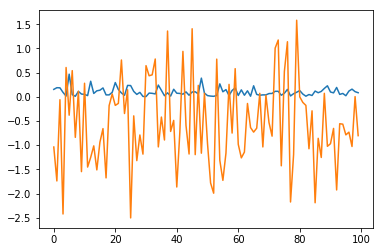

In [17]:
predict = []
for x1,y1 in zip(X_test, y_test):
    feed_dict_train = {x:x1.reshape(1,9), y_true:y1.reshape(1,1)}
    
    pred = sess.run(logits ,feed_dict=feed_dict_train)
    predict.append(pred[0][0])
plt.plot(y_test[0:100])
plt.plot(predict[0:100])
plt.show

Epoch:  0
3.459028743188597
Epoch:  1
0.9819634609249438
Epoch:  2
0.9786446098951536
Epoch:  3
0.9784014809912092
Epoch:  4
0.9782547558524547
Epoch:  5
0.9781473825764445
Epoch:  6
0.9780653525536203
Epoch:  7
0.9780003386620759
Epoch:  8
0.9779467901274994
Epoch:  9
0.9779008526123055


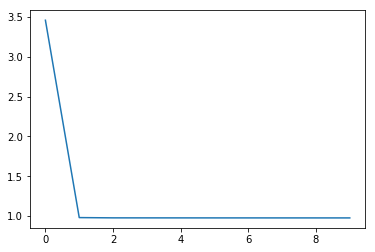

In [18]:
optimize(num_iterations=10)
plt.plot(costy)

In [19]:
predict = []
for x1,y1 in zip(X_test, y_test):
    feed_dict_train = {x:x1.reshape(1,9), y_true:y1.reshape(1,1)}
    
    pred = sess.run(logits ,feed_dict=feed_dict_train)
    predict.append(pred[0][0])

<function matplotlib.pyplot.show(*args, **kw)>

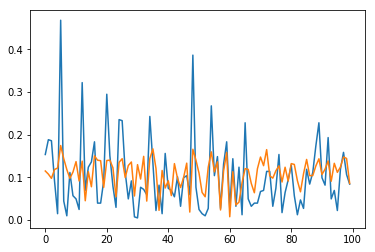

In [20]:
plt.plot(y_test[0:100])
plt.plot(predict[0:100])
plt.show